# Predictive Modeling for COVID-19 Patient Classification: Leveraging Automated Feature Engineering and Hyperparameter Optimization

### Kaggle Dataset Import

In [19]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'covid19-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2633044%2F4504149%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240503%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240503T170611Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D214a3735ac9292506a7c4125a8c61494d533ff4f99695ab1bbb55e3a21bb4a85f666088a052837248b9892e627546df6f826dd72bc830c36e6f4a29951d0db8f436871014891e8480ea84c48f82c4f4c8ed14d5165c89971e472ec058178406a3909b8a4b408d9cbe6da595f367e1a5d72781f0f691b237b0389478e1b72e39a1e37b4ad6e28585e7f85a3cc9d8d5bedc7ab5b3c1c41c7d5c5a1edee73068df6cafc9ceae0cc2e8c1322128204334797a9677e4528d158ed51321c0ba15137737f3fdd97f9f8a0e1fb68c9c385f0c8c801eba22c763a0d0ea9061b8b67e8e6cdd682313e20f770ff4888844b467c9a4ed3c9d67ecf915a6a609743aa959b4fa9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4890659 bytes downloaded
Downloaded and uncompressed: covid19-dataset
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/covid19-dataset/Covid Data.csv


### Imports

In [2]:
pip install featuretools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.1/620.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.0/231.0 kB 14.6 MB/s eta 0:00:00


In [3]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.8 MB/s eta 0:00:00


In [16]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score as accuracy
import featuretools as ft
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import optuna
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

%matplotlib inline

### Data Exploration
#### Initial Exploration:
The dataset contains information about COVID-19 patients, including symptoms, status, and medical history.
There are 21 features and 1,048,576 unique patients in the dataset.
Boolean features have values 1 for "yes," 2 for "no," and 97/99 for missing data.

Features include sex, age, patient type, pneumonia, pregnancy, diabetes, COPD, asthma, immunosuppression, hypertension, cardiovascular disease, chronic renal disease, other diseases, obesity, tobacco use, medical unit type, intubation, ICU admission, and date of death.

#### Target Variable:
The target variable is "classification," representing COVID-19 test findings.
Values 1-3 indicate different degrees of COVID-19 diagnosis, while 4 or higher means the patient is not a carrier or the test is inconclusive.

### Dataset Read

In [5]:
covid = pd.read_csv("/kaggle/input/covid19-dataset/Covid Data.csv")
covid.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [6]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

In [ ]:
covid.nunique()

USMER                     2
MEDICAL_UNIT             13
SEX                       2
PATIENT_TYPE              2
DATE_DIED               401
INTUBED                   4
PNEUMONIA                 3
AGE                     121
PREGNANT                  4
DIABETES                  3
COPD                      3
ASTHMA                    3
INMSUPR                   3
HIPERTENSION              3
OTHER_DISEASE             3
CARDIOVASCULAR            3
OBESITY                   3
RENAL_CHRONIC             3
TOBACCO                   3
CLASIFFICATION_FINAL      7
ICU                       4
dtype: int64

### Data Pre-processing

In [6]:
temp = covid.copy()
temp[temp["DATE_DIED"] == "9999-99-99"] = 1
temp[temp["DATE_DIED"] != "9999-99-99"] = 0
covid.DATE_DIED = temp.DATE_DIED

In [7]:
covid.DATE_DIED = pd.to_numeric(covid.DATE_DIED)

In [8]:
covid.shape

(1048575, 21)

In [9]:
# Select the first 100,000 rows
covid1 = covid.iloc[:100000]
covid1.shape


(100000, 21)

### Exploratory Data Analysis

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

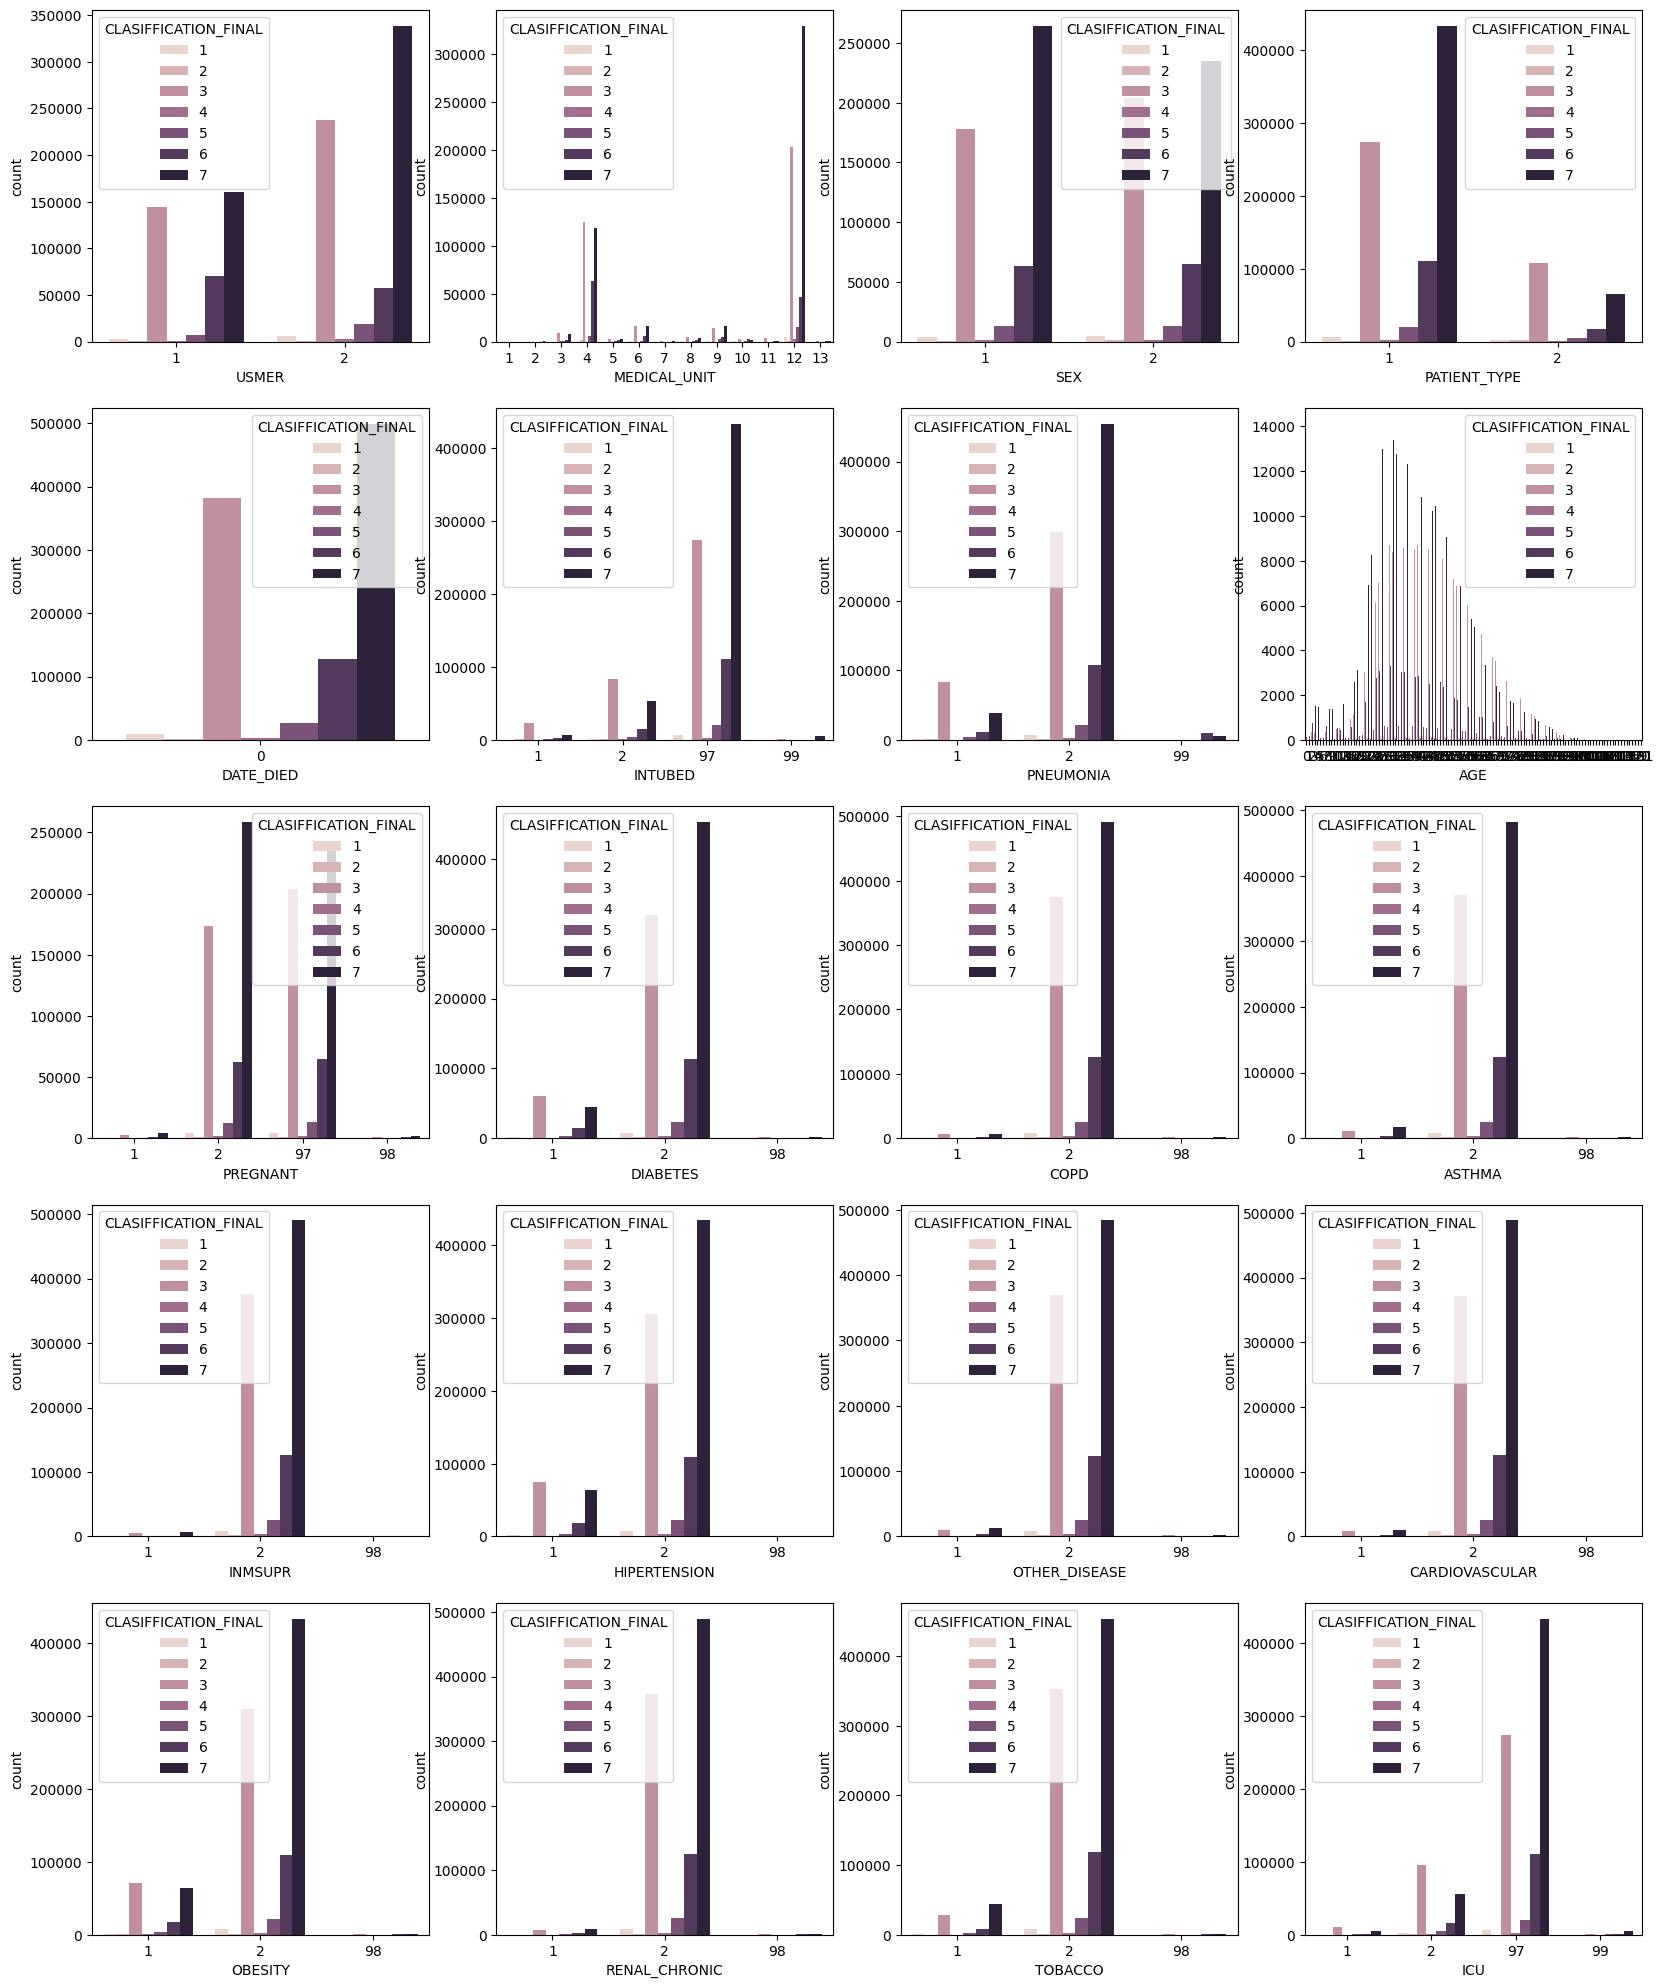

In [ ]:

plt.figure(figsize=(20, 25))
index = 1
temp = covid.drop("CLASIFFICATION_FINAL", axis = 1)

for i in temp.columns:
    plt.subplot(5, 4, index)
    sns.countplot(data=covid, x=i, hue="CLASIFFICATION_FINAL")
    index += 1
plt.show()

### Model Training

In [10]:
X = covid1.drop("CLASIFFICATION_FINAL", axis = 1)
y = covid1.CLASIFFICATION_FINAL

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=0,test_size=0.2)


In [12]:
X_train.shape

(80000, 20)

In [13]:
X_test.shape

(20000, 20)

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [16]:


# Gradient Boosting Machine
gbm_model = GradientBoostingClassifier()
gbm_pipe = Pipeline([('gbm', gbm_model)])
gbm_params = {
    'gbm__n_estimators': [50,],
    'gbm__learning_rate': [0.01],
    'gbm__max_depth': [3]
}
gbm_grid = GridSearchCV(gbm_pipe, param_grid=gbm_params, cv=3, n_jobs=-1)
gbm_grid.fit(X_train_sc, y_train)



GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('gbm', GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gbm__learning_rate': [0.01], 'gbm__max_depth': [3],
                         'gbm__n_estimators': [50]})

In [17]:
# Evaluate GBM
from sklearn.metrics import accuracy_score as accuracy
gbm_pred = gbm_grid.predict(X_test_sc)
print("Gradient Boosting Machine:")
print("Accuracy",accuracy(y_test, gbm_pred))
print('Classification Report',classification_report(y_test, gbm_pred))

Gradient Boosting Machine:
Accuracy 0.5358558043058437


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report               precision    recall  f1-score   support

           1       0.00      0.00      0.00      1684
           2       0.00      0.00      0.00       374
           3       0.60      0.26      0.36     76223
           4       0.00      0.00      0.00       600
           5       0.00      0.00      0.00      5183
           6       0.84      0.05      0.09     25557
           7       0.52      0.91      0.66    100094

    accuracy                           0.54    209715
   macro avg       0.28      0.17      0.16    209715
weighted avg       0.57      0.54      0.46    209715



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Adaptive Boosting
ada_model = AdaBoostClassifier()
ada_pipe = Pipeline([('ada', ada_model)])
ada_params = {
    'ada__n_estimators': [50],
    'ada__learning_rate': [0.01]
}
ada_grid = GridSearchCV(ada_pipe, param_grid=ada_params, cv=3, n_jobs=-1)
ada_grid.fit(X_train_sc, y_train)

GridSearchCV(cv=3, estimator=Pipeline(steps=[('ada', AdaBoostClassifier())]),
             n_jobs=-1,
             param_grid={'ada__learning_rate': [0.01],
                         'ada__n_estimators': [50]})

In [23]:
# Evaluate AdaBoost
ada_pred = ada_grid.predict(X_test_sc)

print('Testing Accuracy',accuracy(y_test, ada_pred))
print('Classification Report',classification_report(y_test, ada_pred))

Training Accuracy:  0.5368214004720693
Testing Accuracy:  0.5380587940776769
Testing Accuracy:  0.5380587940776769


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         1
           3       0.33      0.55      0.41     46438
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.07      0.80      0.13      2185
           7       0.86      0.53      0.66    161091

    accuracy                           0.54    209715
   macro avg       0.18      0.27      0.17    209715
weighted avg       0.73      0.54      0.60    209715



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Contribution


### Feature Engineering:

1. **EntitySet Creation:** Employed the library Featuretools to create an EntitySet 'covid19' and then added the root entity, the main dataframe 'data' with COVID-19 patients data.

2. **DFS:** Automatic generation of numerous new features was carried out employing Deep Feature Synthesis and transformation primitives like 'add_numeric', 'multiply_numeric'. Thus, the dataset was enriched with a considerable number of engineered features that were derived from the existing features.

### Feature Selection Algorithm

1. Firstly, used the correlation matrix to check & remove correlated features which were greater than 0.85, so as to improve model learning.

2. Then removed features which had variance value less than 0.1.

3. Thirdly, used the feature importance function of the various classifiers (GBM, XGB, Rand Forest, etc.) to get important features, and fitted an ensemble classifier on them. .

4. These important features were then recursively selected using RFE based on their importance in model tuning.

5. Finally, normalized all the features in between 0 and 1, selected the features which were above a certain threshold.

### Hyperparameter optimization

 In this project we used Optuna library for hyperparameter optimization of GBM & AdaBoost classifiers.


### Feature Engieering


In [9]:
### Feature Engineering (Contributed by Awais Tariq 23i-7606)
es = ft.EntitySet(id='covid19')

# Add dataframe
es = es.add_dataframe(
    dataframe_name="data",
    dataframe=covid1,
    index="index",
)

# Run deep feature synthesis with transformation primitives
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name='data',
    trans_primitives=['add_numeric', 'multiply_numeric'],  # Choose appropriate primitives
    # max_depth=2  # Adjust as needed
)

feature_matrix.head()


/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:1914: UserWarning: index index not found in dataframe, creating new integer column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/featuretools/synthesis/deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,PREGNANT * RENAL_CHRONIC,PREGNANT * SEX,PREGNANT * TOBACCO,PREGNANT * USMER,RENAL_CHRONIC * SEX,RENAL_CHRONIC * TOBACCO,RENAL_CHRONIC * USMER,SEX * TOBACCO,SEX * USMER,TOBACCO * USMER
index,,,,,,,,,,,,,,,,,,,,,
0,2,1,1,1,0,97,1,65,2,2,...,4.0,2.0,4.0,4.0,2.0,4.0,4.0,2.0,2.0,4.0
1,2,1,2,1,0,97,1,72,97,2,...,97.0,194.0,194.0,194.0,2.0,2.0,2.0,4.0,4.0,4.0
2,2,1,2,2,0,1,2,55,97,1,...,194.0,194.0,194.0,194.0,4.0,4.0,4.0,4.0,4.0,4.0
3,2,1,1,1,0,97,2,53,2,2,...,4.0,2.0,4.0,4.0,2.0,4.0,4.0,2.0,2.0,4.0
4,2,1,2,1,0,97,2,68,97,1,...,194.0,194.0,194.0,194.0,4.0,4.0,4.0,4.0,4.0,4.0


In [25]:
covid11=feature_matrix
covid11.shape

(100000, 441)

#### Feature Selection Algorithm

In [27]:
### Feature Selection Algorithm (Contributed by Awais Tariq 23i-7606)
# Create correlation matrix
corr_matrix = covid11.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.85
to_drop = [column for column in upper.columns if any(upper[column] >= 0.85)]

print('There are {} columns with >= 0.85 correlation.'.format(len(to_drop)))


There are 389 columns with >= 0.85 correlation.


In [28]:
covid11 = covid11[[i for i in feature_matrix if i not in to_drop]]
covid11.shape

(100000, 52)

In [29]:

# Instantiate VarianceThreshold
var_thresh = VarianceThreshold(threshold=0.1)

# Fit and transform on covid11
c11_trans = var_thresh.fit_transform(covid11)

# Get the indices of features to keep
feature_indices = var_thresh.get_support(indices=True)

# Get the column names of the selected features
selected_features = covid11.columns[feature_indices]

# Filter the dataframe to keep only the selected features
c11_trans = covid11[selected_features]

# Check the shape
print(c11_trans.head(2))


       USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE  PNEUMONIA  AGE  DIABETES  COPD  \
index                                                                           
0          2             1    1             1          1   65         2     2   
1          2             1    2             1          1   72         2     2   

       OTHER_DISEASE  OBESITY  ...  ASTHMA * PNEUMONIA  ASTHMA * PREGNANT  \
index                          ...                                          
0                  2        2  ...                 2.0                4.0   
1                  2        1  ...                 2.0              194.0   

       COPD * PNEUMONIA  DIABETES * ICU  DIABETES * PNEUMONIA  \
index                                                           
0                   2.0           194.0                   2.0   
1                   2.0           194.0                   2.0   

       ICU * OTHER_DISEASE  ICU * PREGNANT  ICU * TOBACCO  OBESITY * PREGNANT  \
index                   

In [30]:

# Suppress the ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

X = c11_trans.drop("CLASIFFICATION_FINAL", axis = 1)
y = c11_trans.CLASIFFICATION_FINAL

classifiers = [
    ('Extra Trees', ExtraTreesClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('XGBoost', XGBClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),

]

# Create an ensemble of classifiers
ensemble_clf = VotingClassifier(classifiers, voting='soft')
ensemble_clf.fit(X, y)

# Get feature importances from each classifier
feature_weights = {}
for clf_name, clf in ensemble_clf.named_estimators_.items():
    if hasattr(clf, 'feature_importances_'):
        feature_weights[clf_name] = clf.feature_importances_
    else:

        print(f"This classifier ({clf_name}) does not have important features.")

# Recursive Feature Elimination (RFE)
estimator = GradientBoostingClassifier()  # Choose any estimator
selector = RFE(estimator, n_features_to_select=12, step=2)
selector = selector.fit(X, y)
feature_weights["RFE"] = selector.ranking_

# Aggregate feature weights
all_weights = np.vstack(list(feature_weights.values()))
mean_weights = np.mean(all_weights, axis=0)

# Normalize weights to range from 0 to 1
normalized_weights = (mean_weights - mean_weights.min()) / (mean_weights.max() - mean_weights.min())
print(normalized_weights)
# Select features based on their weights
selected_features = X.columns[normalized_weights > 0.001]  # Adjust threshold as needed
print("Selected features after threshold:")
print(selected_features)
selected_features.shape


[1.00000000e+00 2.36430911e-02 8.88573629e-01 9.35312222e-03
 2.11186838e-03 8.53160490e-02 7.77528032e-01 8.88547613e-01
 7.77626700e-01 6.66501533e-01 5.55299203e-01 4.88427932e-02
 5.58706810e-01 1.14386422e-01 6.66411766e-01 0.00000000e+00
 3.32821984e-01 3.15239877e-01 2.10734598e-02 2.21932667e-01
 7.13349207e-04 9.99652654e-01 9.91131160e-03 2.22490416e-01
 1.96107035e-03 1.11417985e-01 4.43983346e-01 3.34262538e-01
 4.44333720e-01 1.83896289e-03]
Selected features after threshold:
Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'PNEUMONIA', 'AGE',
       'DIABETES', 'COPD', 'OTHER_DISEASE', 'OBESITY', 'ICU + PREGNANT',
       'MEDICAL_UNIT + PATIENT_TYPE', 'MEDICAL_UNIT + SEX',
       'MEDICAL_UNIT + USMER', 'PATIENT_TYPE + SEX', 'SEX + USMER',
       'AGE * CLASIFFICATION_FINAL', 'AGE * USMER', 'ASTHMA * ICU',
       'ASTHMA * PREGNANT', 'COPD * PNEUMONIA', 'DIABETES * ICU',
       'DIABETES * PNEUMONIA', 'ICU * OTHER_DISEASE', 'ICU * PREGNANT',
       'ICU * TOBACCO', 

(28,)

In [31]:
X = c11_trans[selected_features]
y = c11_trans.CLASIFFICATION_FINAL

In [32]:
X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=0,test_size=0.2)

In [38]:
X_train.shape

(80000, 28)

In [39]:
X_test.shape

(20000, 28)

In [35]:

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

### Hyper parameter optimization

In [ ]:
### Hyper parameter optimization (Contributed by Awais Tariq 23i-7606)
# Improving the accuracy and robustness of both GBM and ADABOOST using hyperparmeter optimization using Optuna


# Define objective function for GBM hyperparameter optimization
def objective_gbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2,log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0)
    }
    gbm_model = GradientBoostingClassifier(**params)
    gbm_model.fit(X_train_sc,y_train)
    gbm_pred = gbm_model.predict(X_test_sc)
    return accuracy(y_test, gbm_pred)

# Define objective function for AdaBoost hyperparameter optimization
def objective_ada(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2,log=True),
    }
    ada_model = AdaBoostClassifier(**params)
    ada_model.fit(X_train, y_train)
    ada_pred = ada_model.predict(X_test_sc)
    return accuracy(y_test, ada_pred)

# Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [46]:
# Optimize GBM hyperparameters
study_gbm = optuna.create_study(direction='maximize')
study_gbm.optimize(objective_gbm, n_trials=5)

# Get the best hyperparameters and their respective accuracies
print("GBM Best Trial:")
print(study_gbm.best_trial.params)
print("GBM Best Accuracy:", study_gbm.best_trial.value)


[I 2024-05-03 07:58:33,380] A new study created in memory with name: no-name-8fcf52e2-250b-4683-b9eb-73deb5c9563c
[I 2024-05-03 08:00:57,380] Trial 0 finished with value: 0.9758 and parameters: {'n_estimators': 121, 'learning_rate': 0.016052507845018264, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 7, 'subsample': 0.8791980020926676}. Best is trial 0 with value: 0.9758.
[I 2024-05-03 08:03:17,390] Trial 1 finished with value: 0.991 and parameters: {'n_estimators': 170, 'learning_rate': 0.057699266506595924, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 8, 'subsample': 0.5501312223959389}. Best is trial 1 with value: 0.991.
[I 2024-05-03 08:04:46,810] Trial 2 finished with value: 0.94645 and parameters: {'n_estimators': 79, 'learning_rate': 0.018372186794875865, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 7, 'subsample': 0.5759600637708449}. Best is trial 1 with value: 0.991.
[I 2024-05-03 08:07:57,954] Trial 3 finished with value: 0.9963 and

GBM Best Trial:
{'n_estimators': 124, 'learning_rate': 0.09624170204326406, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2, 'subsample': 0.5729003006239136}
GBM Best Accuracy: 0.9963


In [47]:
# Optimize AdaBoost hyperparameters
study_ada = optuna.create_study(direction='maximize')
study_ada.optimize(objective_ada, n_trials=5)

print("AdaBoost Best Trial:")
print(study_ada.best_trial.params)
print("AdaBoost Best Accuracy:", study_ada.best_trial.value)

[I 2024-05-03 08:10:19,155] A new study created in memory with name: no-name-2839fef9-f829-499a-ac25-764fba9b8bd1
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
[I 2024-05-03 08:10:25,214] Trial 0 finished with value: 0.75275 and parameters: {'n_estimators': 78, 'learning_rate': 0.05336467082817478}. Best is trial 0 with value: 0.75275.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
[I 2024-05-03 08:10:33,505] Trial 1 finished with value: 0.75275 and parameters: {'n_estimators': 97, 'learning_rate': 0.012084128888673834}. Best is trial 0 with value: 0.75275.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  w

AdaBoost Best Trial:
{'n_estimators': 78, 'learning_rate': 0.05336467082817478}
AdaBoost Best Accuracy: 0.75275


### Training Final Models with Best Hyperparameters

In [49]:
# Train final GBM model with best hyperparameters
best_gbm_params = study_gbm.best_trial.params
gbm_model_final = GradientBoostingClassifier(**best_gbm_params)
gbm_model_final.fit(X_train_sc, y_train)


GradientBoostingClassifier(learning_rate=0.09624170204326406, max_depth=4,
                           min_samples_leaf=2, min_samples_split=8,
                           n_estimators=124, subsample=0.5729003006239136)

In [50]:
# Train final AdaBoost model with best hyperparameters
best_ada_params = study_ada.best_trial.params
ada_model_final = AdaBoostClassifier(**best_ada_params)
ada_model_final.fit(X_train_sc, y_train)


AdaBoostClassifier(learning_rate=0.05336467082817478, n_estimators=78)

In [51]:
# Predict accuracy of final models
gbm_pred_final = gbm_model_final.predict(X_test_sc)

# Evaluate final models
gbm_accuracy_final = accuracy(y_test, gbm_pred_final)
gbm_classification_report_final = classification_report(y_test, gbm_pred_final)

print("Final GBM Model Accuracy:", gbm_accuracy_final)
print("Final GBM Model Classification Report:", gbm_classification_report_final)


Final GBM Model Accuracy: 0.99185
Final GBM Model Classification Report:               precision    recall  f1-score   support

           1       0.95      0.57      0.71        65
           2       0.97      0.98      0.97       253
           3       1.00      1.00      1.00     15055
           4       0.34      0.54      0.42        48
           5       0.93      0.94      0.93       211
           6       0.99      0.98      0.98      1143
           7       0.99      1.00      0.99      3225

    accuracy                           0.99     20000
   macro avg       0.88      0.86      0.86     20000
weighted avg       0.99      0.99      0.99     20000



In [52]:
ada_pred_final = ada_model_final.predict(X_test_sc)
ada_accuracy_final = accuracy(y_test, ada_pred_final)
ada_classification_report_final = classification_report(y_test, ada_pred_final)
print("Final AdaBoost Model Accuracy:", ada_accuracy_final)
print("Final AdaBoost Model Classification Report:", ada_classification_report_final)

Final AdaBoost Model Accuracy: 0.75365
Final AdaBoost Model Classification Report:               precision    recall  f1-score   support

           1       0.00      0.00      0.00        65
           2       0.00      0.00      0.00       253
           3       0.76      1.00      0.86     15055
           4       0.00      0.00      0.00        48
           5       0.00      0.00      0.00       211
           6       0.00      0.00      0.00      1143
           7       0.26      0.01      0.01      3225

    accuracy                           0.75     20000
   macro avg       0.15      0.14      0.12     20000
weighted avg       0.61      0.75      0.65     20000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
